In [1]:
import pandas as pd
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, RepeatedKFold,StratifiedKFold, train_test_split
from scipy.stats import randint as sp_randint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

#plt.xticks(rotation=60,fontsize=13)

In [2]:

def plotLearningCurve(_model,_ColList,_xtrain,_ytrain,_cv=5):
    from sklearn.model_selection import learning_curve
    _LC_output=learning_curve(_model, _xtrain[_ColList], _ytrain, n_jobs=-1, cv=_cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    _train_sizes, _train_scores, _test_scores =_LC_output[0],_LC_output[1],_LC_output[2]

    _train_scores_mean,_train_scores_std=np.mean(_LC_output[1], axis=1),np.std(_LC_output[1], axis=1)

    _test_scores_mean,_test_scores_std=np.mean(_LC_output[2], axis=1),np.std(_LC_output[2], axis=1)
    plt.figure(figsize=(15,5))
    plt.title("""Learning Curve to Understand wheather model has high bias, high variance or is ideal\n"""+str(_train_sizes))
    #plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    #print()
     # plot the std deviation as a transparent range at each training set size
    plt.fill_between(_train_sizes, _train_scores_mean - _train_scores_std, _train_scores_mean + _train_scores_std, alpha=0.1, color="r")
    plt.fill_between(_train_sizes, _test_scores_mean - _test_scores_std, _test_scores_mean + _test_scores_std, alpha=0.1, color="g")
    #print(train_scores_mean)  
        # plot the average training and test score lines at each training set size
    plt.plot(_train_sizes, _train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(_train_sizes, _test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
def desc(data):
    from sklearn.preprocessing import normalize
    unique_val=pd.DataFrame(index=data.columns)
    def obtain_variance(data):
        
        if data.dtypes in ('float64','int64'):
             xy1= pd.DataFrame(np.array(data*1.0))
             # variance values less than 0.006 ( threash hold), drop the column
            # If it is categorical binary column and if values 95:5 ratio, you drop the variable.
            #If it is continuous column and variance is less than 0.0066, you drop the variable (remember 0.0066 is value obtained after normalizing the variable).

             return "%3g"%xy1.var()[0]
        elif data.dtypes =='object':
            xy1= pd.DataFrame(data).copy()
            xy1.reset_index()
    def obtain_std(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).std()[0]
    def obtain_mean(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).mean()[0]
    def obtain_min(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).min()[0]
    def obtain_max(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).max()[0]
    for i in data.columns:
        unique_val.loc[i,'dtypes']=data[i].dtypes
        unique_val.loc[i,'null_count']=data[i].isnull().sum() 
        unique_val.loc[i,'total_count']=data[i].notnull().sum()
        unique_val.loc[i,'unique_count']=data[i].nunique()
        unique_val.loc[i,'missing value ratio']="%0.2g" %(data[i].isnull().sum()/len(data)) +'%'
        unique_val.loc[i,'variance of numerics']= obtain_variance(data[i])
        unique_val.loc[i,'std']= obtain_std(data[i])
        unique_val.loc[i,'mean']= obtain_mean(data[i])
        unique_val.loc[i,'min']= obtain_min(data[i])
        unique_val.loc[i,'mean']= obtain_max(data[i])
    return unique_val.sort_values(by=['unique_count','null_count'])

def plot_confusion_matrix(cm):
    plt.figure(figsize=[9, 6])
  
    df_cm = pd.DataFrame(
        cm, index=['Actual: No','Actual: Yes'], columns=['Predicted: No','Predicted: Yes']
    )
    dd= pd.DataFrame(np.array([['TP','FN'],['FP','TN']]))
    print(dd)
    #sns.heatmap(np.array([['TP','FP'],['FN','TN']]), annot=True, annot_kws={"size": 20},fmt='g', yticklabels=False)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20},fmt='g', yticklabels=False,xticklabels=False)
    #plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Actual False      Actual True', fontsize=18)
    plt.ylabel('Predicted True           Predicted False', fontsize=18)
    
def plot_roc_curve(model,X,Y):
    from sklearn.metrics import roc_curve
    pred = model.predict_proba(X)[:,1]

    fpr, tpr, _ = roc_curve(Y,pred) 
    auc = roc_auc_score(Y, pred) 

    #print(fpr,tpr,auc)
    
    plt.figure(figsize=(12,8)) 
    plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.legend(loc=4) 

def plot_pr_curve(model,X,Y):
    fig= plt.figure(figsize=(12,7))
    probas = model_lr.predict_proba(X)[:,1]
    pred = model_lr.predict(X)

    #fpr, tpr, _ = roc_curve(Y,pred) 
    precision, recall, thresholds = precision_recall_curve(Y, probas)
    f1 = f1_score(Y, pred)
    auc_s = auc(recall, precision)
    #f1,auc
    print(recall[:])
    print('Logistic: f1=%.3f auc=%.3f' % (f1, auc_s))
    no_skill=len(Y[Y==1]) / len(Y)
    plt.plot([0, 1], [no_skill, no_skill], marker='^',linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.ylabel('Precison',fontsize=25) 
    plt.xlabel('Recall',fontsize=25)
    plt.legend(loc=4)
    
def classificationModelfit_CV(ml_model,dataframe, Y,cols, rstate = 12, thres = 0.5,  plotROC=0):
    i = 1
    roc_scores = []
    tpr_scores=[]
    fpr_scores=[]
    precision_scores=[]
    recall_scores=[]
    confusion_matrix_scores=[]
    accuracy_scores=[]
    f1_scores=[]
    PRCprecisions=[]
    PRCrecalls=[]
    PRCauc_scores=[]
    Number_of_Trues=[]
    df1 = dataframe.copy()
    df1 = dataframe[cols]
    cv_scoredf=pd.DataFrame()
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,Y):
        
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = Y.loc[df_index],Y.loc[test_index]
        #print(xtr.shape,xvl.shape,ytr.shape,yvl.shape)
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
        
        #plot_roc_curve(model,xtr,ytr)
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        
        # ROC Matrix Data
        fpr, tpr, ROC_Threshholds = roc_curve(yvl,pred_probs[:,1]) 
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        accuracy_score1 = accuracy_score(yvl,pred_val)
        
        # Precession Recall matrix Data
        PRCprecision, PRCrecall, _ = precision_recall_curve(yvl, pred_probs[:,1])
        f1_sc = f1_score(yvl, pred_val)
        Number_of_True=len(yvl[yvl==1]) / len(yvl)
        PRCauc= auc(PRCrecall,PRCprecision)
        
        cm=confusion_matrix(yvl,pred_val)
        if plotROC==3:
            plot_confusion_matrix(cm)
         # Save scores

        roc_scores.append(roc_score)
        fpr_scores.append(fpr)
        tpr_scores.append(tpr)
        recall_scores.append(recall)
        precision_scores.append(precision)
        confusion_matrix_scores.append(cm)
        accuracy_scores.append(accuracy_score1)
        f1_scores.append(f1_sc)
        PRCprecisions.append(PRCprecision)
        PRCrecalls.append(PRCrecall)
        Number_of_Trues.append(Number_of_True)
        PRCauc_scores.append(PRCauc)
        
        i+=1   
    cv_scoredf['fpr_scores'] =fpr_scores
    cv_scoredf['tpr_scores'] =tpr_scores
    cv_scoredf['roc_scores'] =roc_scores
    cv_scoredf['recall_scores'] =recall_scores
    cv_scoredf['precision_scores'] =precision_scores
    cv_scoredf['confusion_matrix_scores']=confusion_matrix_scores
    cv_scoredf['accuracy_scores'] =accuracy_scores
    cv_scoredf['f1_scores'] =f1_scores
    cv_scoredf['PRCprecisions'] =PRCprecisions
    cv_scoredf['PRCrecalls'] =PRCrecalls
    cv_scoredf['Number_of_Trues'] =Number_of_Trues
    cv_scoredf['PRCauc_scores'] =PRCauc_scores
    
    
    if plotROC==1:
        plt.figure(figsize=(26,10))
        plt.title("""   ROC(Reciever Operating) Curve
    (Cross Validation)
    """,color='blue')
        #plt.plot(fpr,tpr,label="Non-CV AUC-ROC="+str("%  0.2f"%auc), linewidth=7,color='magenta') 
        for i in range(5):
            x = np.linspace(0, 1, 1000)
            plt.plot(x, x, linestyle='-')
            
            plt.plot(fpr_scores[i],tpr_scores[i],label="CV set=%i, Accuracy=%0.2f, AUC= %0.2f, Recall=%0.2f, Precison=%0.2f"
                     %(i,accuracy_scores[i],roc_scores[i],recall_scores[i],precision_scores[i])
                     ) 
            plt.legend(loc=4,fontsize=25)
            plt.xlabel('False Positive Rate') 
            plt.ylabel('True Positive Rate')          
    
    elif plotROC==2:  
        plt.figure(figsize=(26,10))
        plt.title("""   Precision Recall Curve
    (Cross Validation)
    """,color='blue')
        plt.plot([0, 1], [Number_of_Trues[0], Number_of_Trues[0]], marker='^',linestyle='--', label='Number of true values=%0.2f' %Number_of_Trues[0])

        for i in range(5):
                #  print("CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, Number_of_Trues=%0.2f, prcAUC_scores=%0.2f "
                #       %(i, accuracy_scores[i], f1_scores[i], Number_of_Trues[i], PRCauc_scores[i]  ))
                
                plt.plot(PRCrecalls[i],PRCprecisions[i], marker='.', 
                         label="CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, prcAUC_scores=%0.2f,Recall=%0.2f, Precison=%0.2f "
                      %(i, accuracy_scores[i], f1_scores[i], PRCauc_scores[i],recall_scores[i],precision_scores[i]  ))
                plt.ylabel('Precison',fontsize=25) 
                plt.xlabel('Recall',fontsize=25)
                plt.legend(loc=4,fontsize=25)         
    else:
        for i in range(5):
            print('\n{} of kfold {}'.format(i,kf.n_splits))
            sufix = ""
            msg = ""
            msg += "CV1 set=%i,Accuracy=%0.2f, AUC= %0.2f, Recall=%0.2f, Precison=%0.2f"%(i,accuracy_scores[i],roc_scores[i],recall_scores[i],precision_scores[i])
            print("{}".format(msg))
            print(confusion_matrix_scores[i])
            print("CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, Number_of_Trues=%0.2f,prcAUC_scores=%0.2f, Recall=%0.2f, Precison=%0.2f"
              %(i,accuracy_scores[i],f1_scores[i],Number_of_Trues[i], PRCauc_scores[i],recall_scores[i],precision_scores[i] ))
            
    return cv_scoredf

def regressionModelfit_CV(alg, cols,  x, y,algo_name):
    #Fit the algorithm on the data
    print('------------      ' + algo_name + '     ------------')
    _list1=[]
    _df=pd.DataFrame(columns=[algo_name])
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import cross_validate
    xdata= x[cols]
    ydata=y
    alg.fit(xdata, ydata)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xdata)

    
    cv_score = cross_val_score(alg, xdata, ydata, cv=4,scoring= 'neg_mean_squared_error')
    #Perform cross-validation:
    cv_matrix_score= cross_validate(alg, xdata, ydata, cv=4,scoring=(
                         'r2', 
                         'neg_mean_absolute_error',
                         'neg_mean_squared_error'
                         ),
                         return_train_score=True,verbose=0)
    #return cv_matrix_score
    avg_model_Scores=pd.DataFrame(cv_matrix_score).mean()
    for i in avg_model_Scores.index:
        
        if 'neg' in i :
            score="%s =%0.2f" %(i, np.sqrt(avg_model_Scores[i]*-1) )
            _df.loc[i]=np.sqrt(avg_model_Scores[i]*-1)
            print(score)
        else:
            score="%s =%0.2f" %(i, avg_model_Scores[i] )
            _df.loc[i]=avg_model_Scores[i]
            print(score)
    return _df[algo_name]
    #dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    #submission.to_csv(filename, index=False)

def getLinearModelScore(_model, xTrainingData,yTrainingData,columnlist):
    xTrainingData=xTrainingData[columnlist]
    x_train, x_test, y_train, y_test = train_test_split(xTrainingData,yTrainingData, test_size =0.3)
    _model.fit(x_train, y_train)
    ptrain = _model.predict(x_train)
    ptest = _model.predict(x_test)
    from sklearn.metrics import mean_squared_error
    print("train MSE="%(mean_squared_error(ptrain,y_train)))
    print("test MSE="%(mean_squared_error(ptest,y_test)))

In [3]:
def crossTabHistGramPlot(groupColumn, BinaryValColumn, Dataframe):
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    plt1.suptitle("Catagorical Cols Analysis with status/label columns " + BinaryValColumn)
    for colname in groupColumn:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        CreditHistory_loanStatus = pd.crosstab(Dataframe[colname], Dataframe[BinaryValColumn])
        CreditHistory_loanStatus.plot(kind='bar', stacked=True, grid=False, ax = ax1)
        plt1.xticks(rotation=12,fontsize=25)
        plt1.xlabel(colname,fontsize=25)
        plt1.ylabel(BinaryValColumn)
        
        plt1.legend(fontsize=20)
        #plt1.title(colname)
    plt1.show()

In [4]:
train_org=pd.read_csv(r"C:\Users\SaurabhM\Jupyter Project Files\My Works\Big Mart Predicition\train.csv")
test_org=pd.read_csv(r"C:\Users\SaurabhM\Jupyter Project Files\My Works\Big Mart Predicition\test.csv")
train=train_org.copy()
test=test_org.copy()
label_col='Item_Outlet_Sales'
ntest=test.shape[1]
print(train.shape,test.shape)

(8523, 12) (5681, 11)


In [5]:
train_test=pd.concat([train_org,test_org],ignore_index=True)

In [6]:
test_org.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


In [7]:
col=test_org.columns

In [8]:
col

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [9]:
col2=train_org.columns
col2

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [52]:
def bar_plot(x,y,name1=" ",name2=" "):
    fig = plt.figure(figsize = (15, 10)) 
  
    # creating the bar plot 
    plt.bar(x, y, color ='maroon',  
            width = 0.4) 
    plt.xlabel(name1) 
    plt.ylabel(name2)
    if name1!=" " and name2!=" ":
        plt.title(name2+" vs "+name1) 
    plt.show() 
    

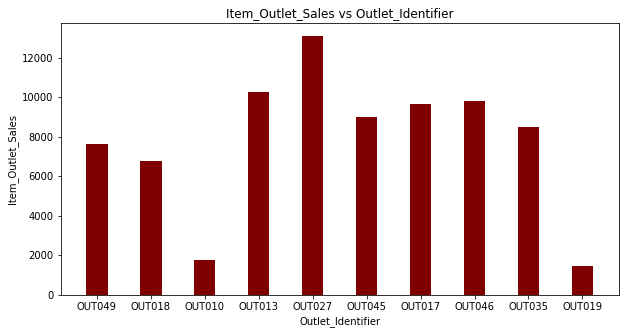

In [23]:
bar_plot(train_org['Outlet_Identifier'], train_org['Item_Outlet_Sales'],"Outlet_Identifier","Item_Outlet_Sales")

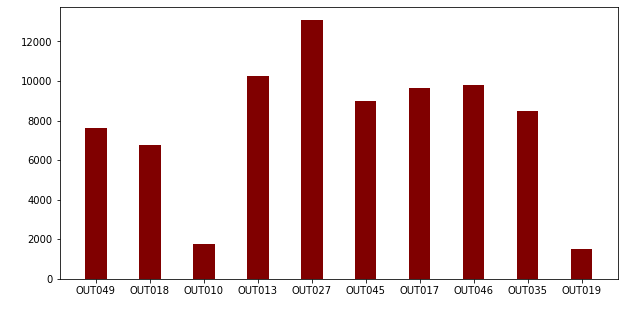

In [26]:
bar_plot(train_org['Outlet_Identifier'], train_org['Item_Outlet_Sales'])

In [45]:
def categorical_columns(x):
    col=x.columns
    a=[]
    for columnss in col:
        if x[columnss].dtypes=='O':
            a.append(columnss)
    return a

x=categorical_columns(train_org)
print(x)

['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


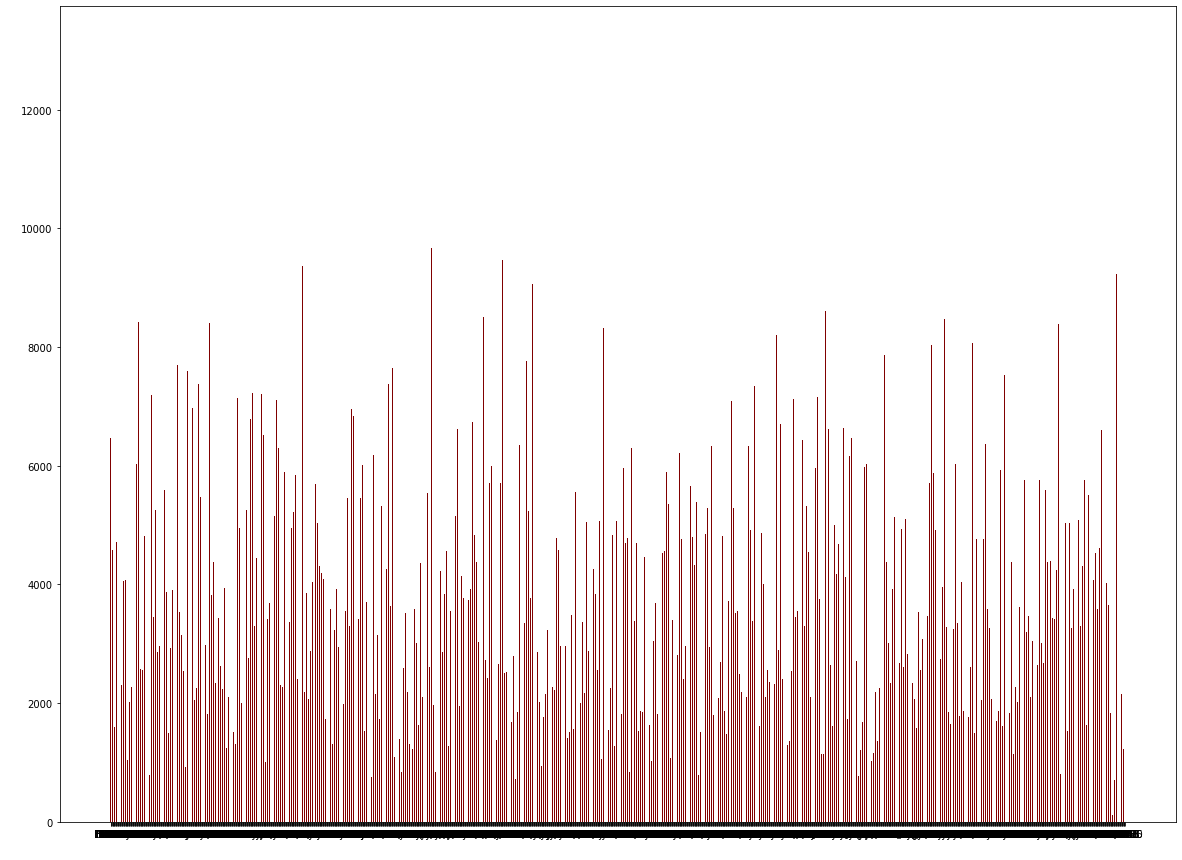

In [46]:
bar_plot(train_org['Item_Identifier'], train_org['Item_Outlet_Sales'])

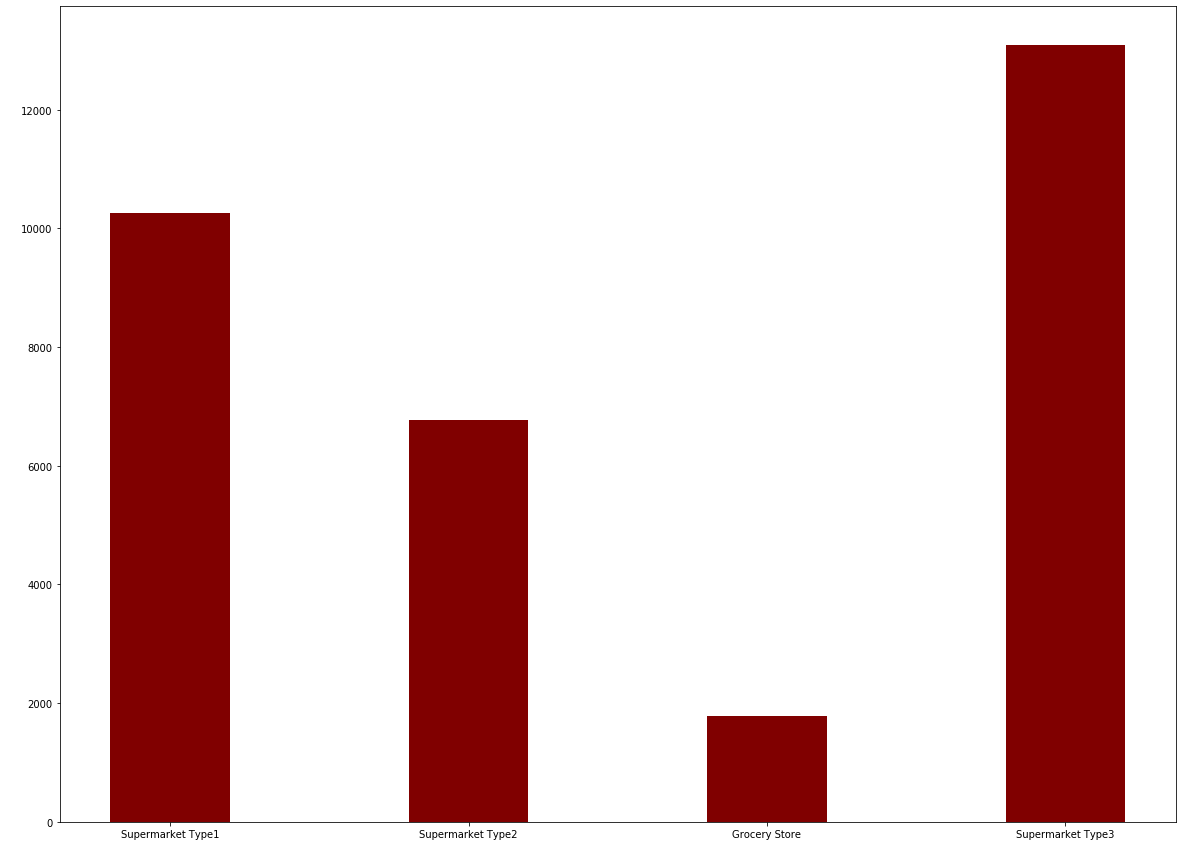

In [47]:
bar_plot(train_org['Outlet_Type'], train_org['Item_Outlet_Sales'])

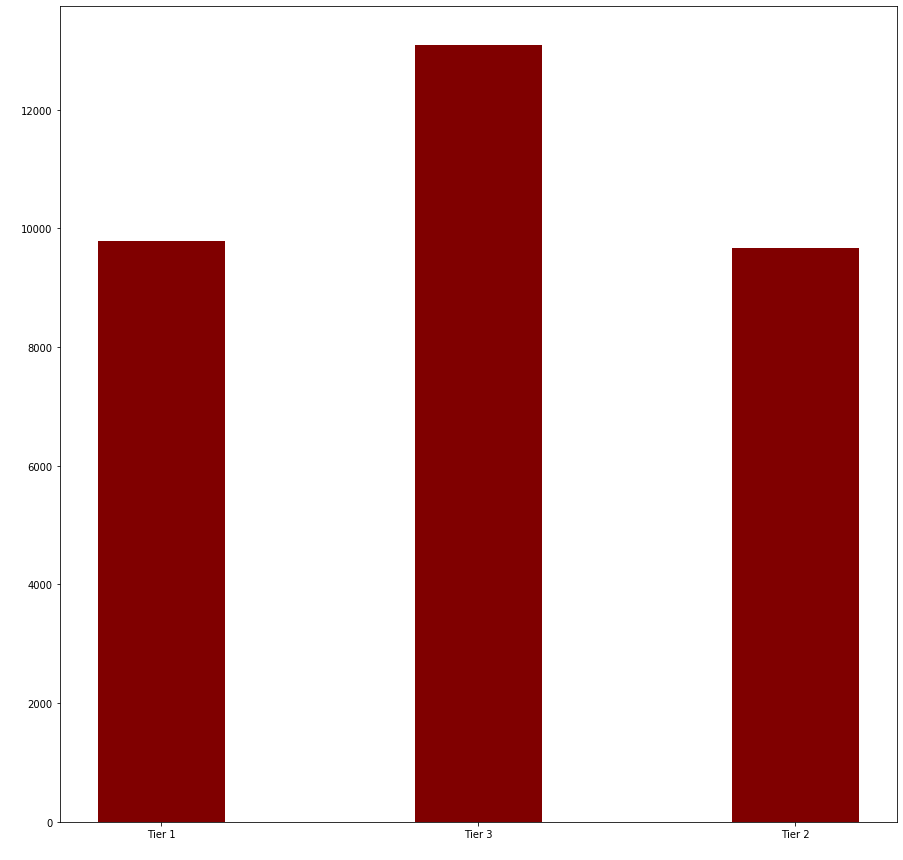

In [49]:
bar_plot(train_org['Outlet_Location_Type'], train_org['Item_Outlet_Sales'])

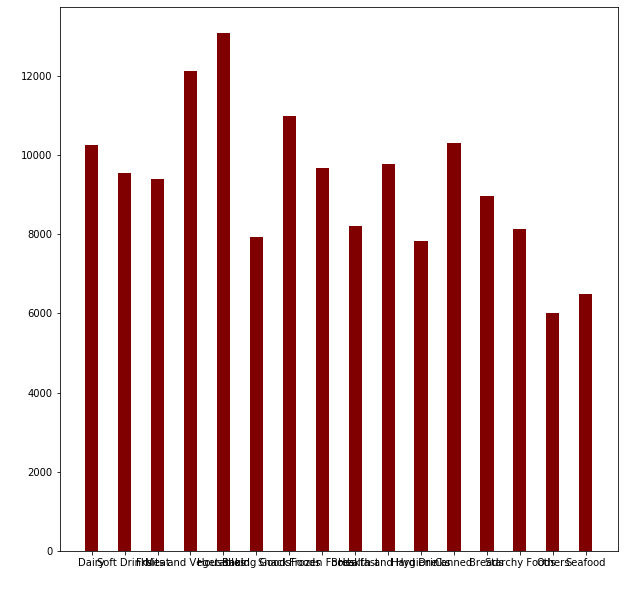

In [51]:
bar_plot(train_org['Item_Type'], train_org['Item_Outlet_Sales'])

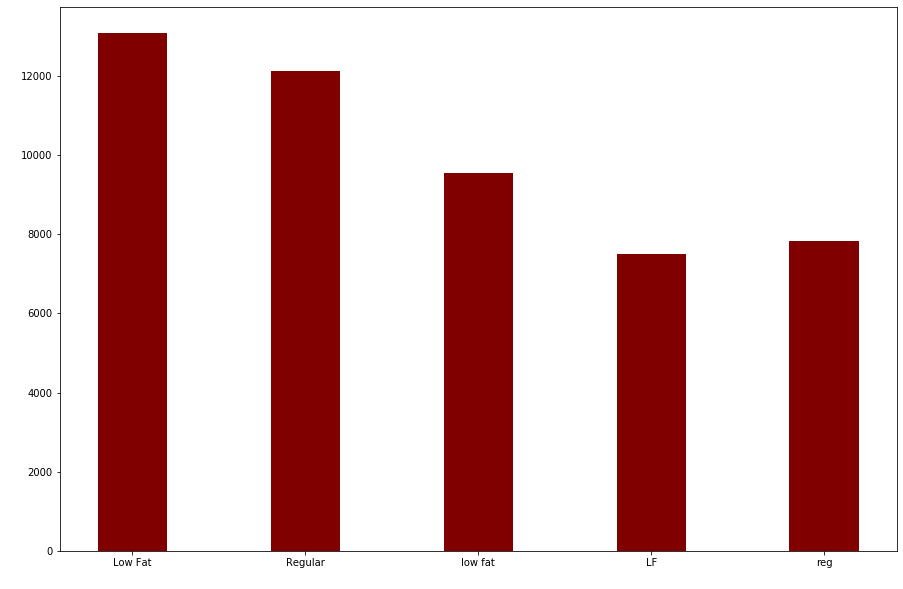

In [53]:
bar_plot(train_org['Item_Fat_Content'], train_org['Item_Outlet_Sales'])

In [54]:
# 
#  1) Item Fat content Categories are mis-spelled
#  2) the Item Type , there are many different categories, So it need to merged somehow
#  3) Super market2 and super market 3 can be merged in Outlet type, As sub categrory are not distributed properly.

# We use
print('\nModified Categories for :' , 'Item_Fat_Content')
train_test['Item_Fat_Content'] = train_test['Item_Fat_Content'].replace({'LF': 1,
                                                                         'Low Fat':1,
                                                                         'low fat':1,
                                                                         'reg':2,
                                                                         'Regular':2
                                                                        })



Modified Categories for : Item_Fat_Content


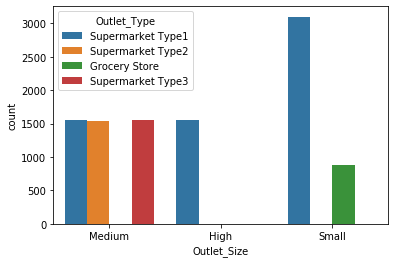

In [55]:
sns.countplot('Outlet_Size',hue='Outlet_Type',data=train_test)


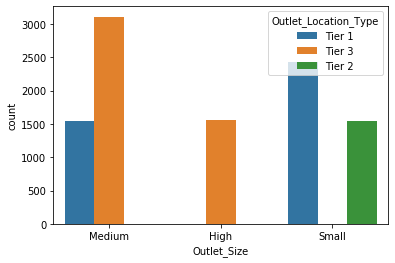

In [56]:
sns.countplot('Outlet_Size',hue='Outlet_Location_Type',data=train_test)

In [57]:
train.groupby(['Outlet_Identifier'])['Outlet_Type'].agg(pd.Series.mode)

Outlet_Identifier
OUT010        Grocery Store
OUT013    Supermarket Type1
OUT017    Supermarket Type1
OUT018    Supermarket Type2
OUT019        Grocery Store
OUT027    Supermarket Type3
OUT035    Supermarket Type1
OUT045    Supermarket Type1
OUT046    Supermarket Type1
OUT049    Supermarket Type1
Name: Outlet_Type, dtype: object

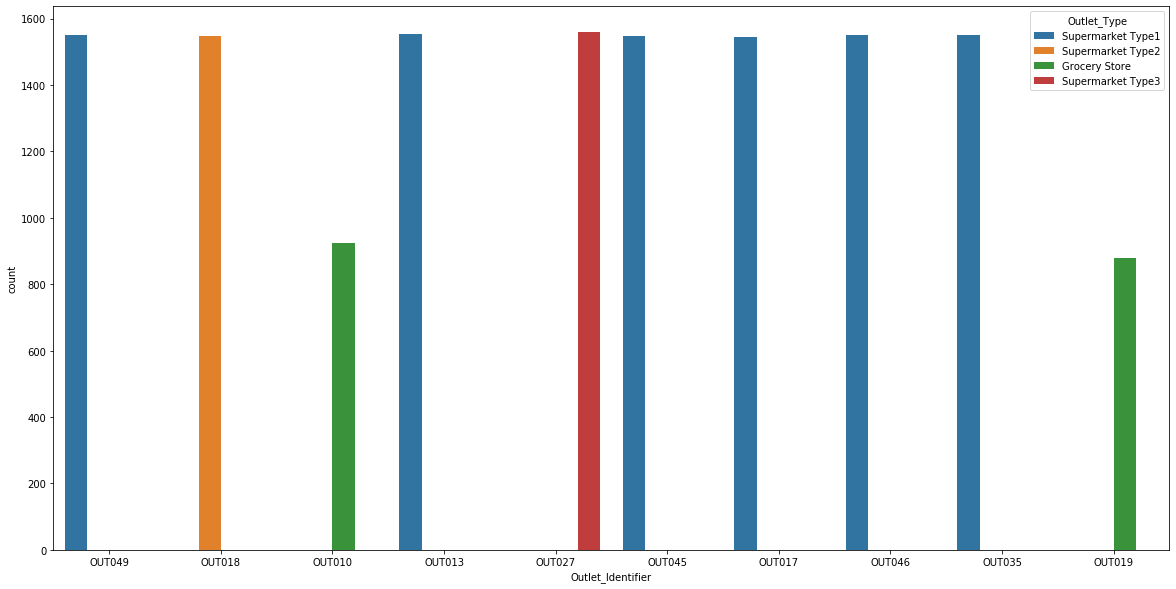

In [60]:
plt.figure(figsize=(20,10))
sns.countplot('Outlet_Identifier',hue='Outlet_Type',data=train_test)

In [61]:
#train_test.pivot_table('Outlet_Size',index='Outlet_Identifier',aggfunc=pd.Series.mode)
test.groupby(['Outlet_Identifier'])['Outlet_Type'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Identifier
OUT010        Grocery Store
OUT013    Supermarket Type1
OUT017    Supermarket Type1
OUT018    Supermarket Type2
OUT019        Grocery Store
OUT027    Supermarket Type3
OUT035    Supermarket Type1
OUT045    Supermarket Type1
OUT046    Supermarket Type1
OUT049    Supermarket Type1
Name: Outlet_Type, dtype: object

In [62]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [63]:
train.groupby(['Outlet_Location_Type'])['Outlet_Size'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Location_Type
Tier 1     Small
Tier 2     Small
Tier 3    Medium
Name: Outlet_Size, dtype: object

In [67]:
nulls_loc=train[train['Outlet_Size'].isna()]['Outlet_Location_Type'].value_counts().index
print(nulls_loc)
train[train['Outlet_Size'].isna()].groupby(['Outlet_Identifier'])['Outlet_Location_Type'].agg(pd.Series.mode)

Index(['Tier 2', 'Tier 3'], dtype='object')


Outlet_Identifier
OUT010    Tier 3
OUT017    Tier 2
OUT045    Tier 2
Name: Outlet_Location_Type, dtype: object

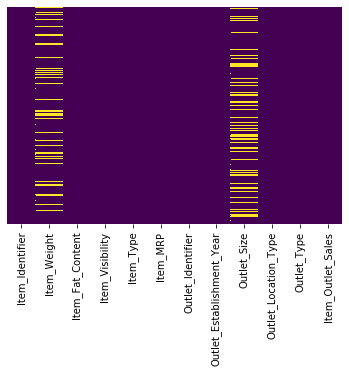

In [68]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

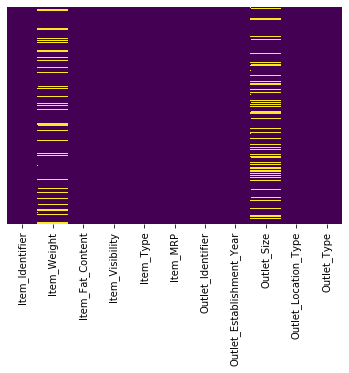

In [69]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [70]:
train.groupby(['Outlet_Location_Type'])['Outlet_Size'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Location_Type
Tier 1     Small
Tier 2     Small
Tier 3    Medium
Name: Outlet_Size, dtype: object

In [71]:
train.groupby(['Outlet_Location_Type'])['Outlet_Type'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Location_Type
Tier 1    Supermarket Type1
Tier 2    Supermarket Type1
Tier 3    Supermarket Type3
Name: Outlet_Type, dtype: object

In [72]:
train.groupby(['Outlet_Type'])['Outlet_Size'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object

In [73]:
cond=(train_test['Outlet_Size'].isna())
train_test.loc[cond & (train_test['Outlet_Identifier']=='OUT010') & (train_test['Outlet_Type']=='Grocery Store'),'Outlet_Size']='Medium'
train_test.loc[cond & (train_test['Outlet_Identifier']=='OUT045') & (train_test['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']='Small'
train_test.loc[cond & (train_test['Outlet_Identifier']=='OUT017') & (train_test['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']='Small'

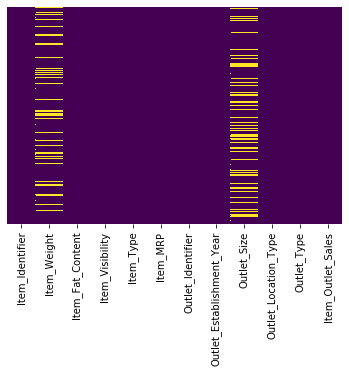

In [74]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [76]:
missing_value=train.isnull().sum()
print (missing_value)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [77]:
# Encoding Outlet_Size

In [78]:
train_test['Outlet_Size']=train_test['Outlet_Size'].replace({'Small':1,
                                                            'Medium':2,
                                                            'High':3})

In [79]:
# Imputing nulls in Item_Weight

In [81]:
cond=(train_test['Item_Weight'].isna())
train_test.loc[cond,'Item_Weight']
map1=dict(train_test.groupby(['Item_Identifier'])['Item_Weight'].median())
map1
#pd.pivot_table('Item_Weight',index='Item_Identifier',aggfunc=np.mean())
train_test.loc[cond,'Item_Weight']=train_test.loc[cond,'Item_Identifier'].apply(lambda x :map1[x] )

In [82]:
train_test['Item_Visibility'].isna().sum()

0

In [83]:
train[train['Item_Visibility']==0]['Item_Identifier'].nunique()#groupby(['Item_Identifier'])Item_Visibility

446